https://keras.io/examples/nlp/neural_machine_translation_with_transformer/

In [1]:
pip install icecream more_itertools

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# only needed for colab
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import os
# os.chdir('/content/drive/MyDrive/SYMBA/2022-07-20-RNNAttention')
os.chdir("..")

In [4]:
os.listdir()

['source', 'notebooks', 'dev', 'README.md', 'test']

In [5]:
import sys
import os
from icecream import ic 
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from source.read_amplitudes import read_amplitudes, fix_operator_num_args, get_tree, fix_tree, fix_subscript, fix_subscripts, read_amplitudes_and_squares
  

In [6]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization


2022-07-20 14:14:10.615621: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-20 14:14:10.618316: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local//lib:
2022-07-20 14:14:10.618329: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Reading in Data

In [7]:
os.listdir()

['source', 'notebooks', 'dev', 'README.md', 'test']

In [8]:
amplitudes_file = "../data.nosync/QED_amplitudes_TreeLevel_UpTo3to3.txt"
sqamplitudes_file = "../data.nosync/QED_sqamplitudes_TreeLevel_UpTo3to3.txt"

In [9]:
X = []
with open(amplitudes_file, 'r') as f:
    for line in f.readlines() :
        line = line.split(";")
        # have to remove new line character for some reason
        line[-1] = line[-1].replace("\n", "")
        # line = tf.strings.join(['[START]', line, '[END]'], separator=' ')
        # X.append(['[START]'] + line + ['[END]'])
        X.append(line)

y = []
with open(sqamplitudes_file, 'r') as f:
    for line in f.readlines() :
        line = line.split(";")
        # have to remove new line character for some reason
        line[-1] = line[-1].replace("\n", "")
        # y.append(['[START]'] + line + ['[END]'])
        y.append(line)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

In [11]:
np.array(X_train[0])

array(['Prod', '1/162', 'Prod', 'i', 'Prod', 'Pow', 'e', '4', 'Prod',
       'Pow', 'Sum', 'Pow', 'm_s', '2', 'Sum', 's_23', 'Prod', '1/2',
       'reg_prop', '-1', 'Prod', 'Pow', 'Sum', 'Pow', 'm_s', '2', 'Sum',
       's_12', 's_13', 'Prod', '-1', 's_15', 's_23', 'Prod', '-1', 's_25',
       'Prod', '-1', 's_35', 'Prod', '1/2', 'reg_prop', '-1', 'Prod',
       'Pow', 'Sum', 's_15', 'Prod', '-1/2', 'reg_prop', '-1', 'Sum',
       'Prod', 'p_1', 'alpha_33', 'Prod', 'p_1', 'alpha_12', 'Prod',
       'gamma', 'alpha_33', 'alpha_47', 'alpha_11', 'Prod', 'gamma',
       'alpha_28', 'alpha_4', 'alpha_41', 'Prod', 'A^(*)', 'i_5',
       'alpha_12', '(p_5)', 'Prod', 'A^(*)', 'i_1', 'alpha_28', '(p_6)',
       'Prod', 'd^(*)', 'i_2', 'alpha_4', '(p_1)_v', 'Prod', 'd', 'i_3',
       'alpha_41', '(p_4)_v', 'Prod', 's', 'i_4', 'alpha_11', '(p_2)_u',
       's^(*)', 'i_0', 'alpha_47', '(p_3)_v', 'Sum', 'Prod', '1/2',
       'Prod', 'p_1', 'alpha_12', 'Prod', 'p_2', 'alpha_2', 'Prod',
       'gamma

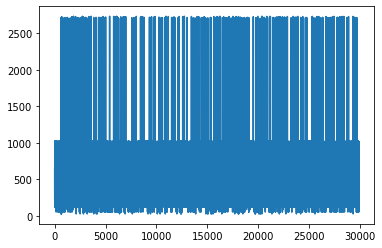

In [12]:
plt.plot([len(x) for x in X_train])

In [13]:
vocab_size = 400
sequence_length = 250
batch_size = 16

In [14]:
X_train_idx_okay = np.where([len(x) < sequence_length for x in X_train])[0]
X_val_idx_okay = np.where([len(x) < sequence_length for x in X_val])[0]
X_test_idx_okay = np.where([len(x) < sequence_length for x in X_test])[0]
ic(len(X_train_idx_okay));
ic(len(X_test_idx_okay));

ic| len(X_train_idx_okay): 19266
ic| len(X_test_idx_okay): 2438


In [15]:
X_train_short = [X_train[i] for i in X_train_idx_okay]
y_train_short = [y_train[i] for i in X_train_idx_okay]

X_val_short = [X_val[i] for i in X_val_idx_okay]
y_val_short = [y_val[i] for i in X_val_idx_okay]

X_test_short = [X_test[i] for i in X_test_idx_okay]
y_test_short = [y_test[i] for i in X_test_idx_okay]

In [16]:
X_train_text = [" ".join(x) for x in X_train_short]
y_train_text = [" ".join(yy) for yy in y_train_short]

X_test_text = [" ".join(x) for x in X_test_short]
y_test_text = [" ".join(yy) for yy in y_test_short]

X_val_text = [" ".join(x) for x in X_val_short]
y_val_text = [" ".join(yy) for yy in y_val_short]

# Vectorization

In [17]:
def custom_standardization(input_string):
    return input_string

In [18]:
X_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=None,
)

y_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length+1,
    standardize=None,
)

2022-07-20 14:14:17.562743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 14:14:17.562909: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local//lib:
2022-07-20 14:14:17.563125: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local//lib:
2022-07-20 14:14:17.563299: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/l

In [19]:
X_vectorization.adapt(X_train_text)
y_vectorization.adapt(y_train_text)

In [20]:
X_vectorization(X_train_text[0])

<tf.Tensor: shape=(250,), dtype=int64, numpy=
array([  2, 144,   2,  51,   2,   6, 107,  74,   2,   6,  52,  74,   2,
         6,   4,   6,  92,   7,   4,   2,   8,  53,   2,  76,  49,   2,
        76,  80,   2,  76,  75,   2,  76,  77,   2,   8,  79,   2, 104,
        14,   5,   2,   6,   4,   6,  92,   7,   4,  53,   2,   8,  14,
         5,   2,   6,   4,   6,  92,   7,   4,  53,   2,   5,  49,   2,
         5,  75,   2,   8,  14,   5,   4,   2,  84,  35,   2,   3,  27,
        34,  28,   2,   3,  27,  19,  41,   2,   3,  32,  29,  26,   2,
         3,  32,  21,  37,   2,   3,  35,  41,  21,   2,  67,  11,  28,
        38,   2,  66,  12,  34,  45,   2,  66,   9,  19,  42,   2,  67,
        15,  37,  47,   2,  69,  10,  26,  54,  68,  13,  29,  78,   4,
         2,  83,  35,   2,   3,  27,  40,  23,   2,   3,  27,  18,  22,
         2,   3,  32,  20,  16,   2,   3,  32,  36,  30,   2,   3,  35,
        22,  36,   2,  67,  11,  23,  38,   2,  66,  12,  40,  45,   2,
        66,   9,  

In [21]:
def format_dataset(X, y):
    X_vec = X_vectorization(X)
    y_vec = y_vectorization(y)
    return (
        {
            "encoder_inputs": X_vec,
            "decoder_inputs": y_vec[:, :-1],
        },
        y_vec[:, 1:],
    )


def make_dataset(X_text, y_text):
    dataset = tf.data.Dataset.from_tensor_slices((X_text, y_text))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(X_train_text, y_train_text)
val_ds = make_dataset(X_val_text, y_val_text)
test_ds = make_dataset(X_test_text, y_test_text)


In [22]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")


inputs["encoder_inputs"].shape: (16, 250)
inputs["decoder_inputs"].shape: (16, 250)
targets.shape: (16, 250)


2022-07-20 14:14:21.315141: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [26]:
for inputs, targets in train_ds.take(1):
    print(inputs)
    print(targets)

{'encoder_inputs': <tf.Tensor: shape=(16, 250), dtype=int64, numpy=
array([[  2, 141,   2, ...,   0,   0,   0],
       [  2, 127,   2, ...,   0,   0,   0],
       [  2, 141,   2, ...,   0,   0,   0],
       ...,
       [  2, 114,   2, ...,   0,   0,   0],
       [  2, 126,   2, ...,   0,   0,   0],
       [  2, 133,   2, ...,   0,   0,   0]])>, 'decoder_inputs': <tf.Tensor: shape=(16, 250), dtype=int64, numpy=
array([[  5,   2, 128, ...,   2,   6,  18],
       [  5,   2,  69, ...,   3,   5,   3],
       [  5,   2,  84, ...,   2,  13,  11],
       ...,
       [  5,   2,  78, ...,  48,   3,   5],
       [  5,   2,  89, ...,   6,   2,   3],
       [  5,   2,  92, ...,   2,  13,  17]])>}
tf.Tensor(
[[  2 128   2 ...   6  18   2]
 [  2  69   2 ...   5   3  22]
 [  2  84   2 ...  13  11   2]
 ...
 [  2  78   2 ...   3   5   3]
 [  2  89   2 ...   2   3   5]
 [  2  92   2 ...  13  17  48]], shape=(16, 250), dtype=int64)


2022-07-20 14:15:16.034537: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [23]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


In [24]:
embed_dim = 256
latent_dim = 512
num_heads = 6

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)


In [25]:
epochs = 1  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)


Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   166400      ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   1841664     ['positional_embedding[

KeyboardInterrupt: 

In [ ]:
y_vocab = y_vectorization.get_vocabulary()
y_index_lookup = dict(zip(range(len(y_vocab)), y_vocab))
max_decoded_sentence_length = 250


def decode_sequence(input_sentence):
    tokenized_input_sentence = X_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = y_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = y_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [ ]:
decode_sequence(X_val_text[0])

'[start] 227 prod i prod pow e 4 prod pow sum pow mu 2 sum s45 prod 12 regprop 1 prod pow sum pow mu 2 sum prod 1 s24 prod 1 s25 s45 prod 12 regprop 1 prod pow sum pow mc 2 sum pow mu 2 s23 prod 1 s14 prod 1 s15 prod 1 s24 prod 1 s25 s45 prod 12 regprop 1 sum prod p2 alpha11 prod gamma alpha11 alpha19 alpha11 prod gamma alpha11 alpha19 alpha11 prod gamma alpha11 alpha19 alpha11 prod c i1 alpha3 p1u prod c i3 alpha11 p6v prod t i0 alpha11 p1u prod t i5 alpha3 p2v prod u i4 alpha11 p4u u i2 alpha6 p5v sum prod 12 prod p4 alpha11 prod gamma alpha11 alpha1 alpha21 prod gamma alpha11 alpha1 alpha11 prod gamma alpha11 alpha11 alpha19 prod gamma alpha11 alpha11 alpha19 prod gamma alpha11 alpha24 alpha17 prod c i1 alpha11 p3v prod c i3 alpha3 p6v prod t i0 alpha11 p1u prod t i5 alpha11 p2v prod u i4 alpha11 p4u prod t i5 alpha11 p5v prod prod p5 alpha11 prod gamma alpha11 alpha22 alpha21 prod gamma alpha7 alpha19 alpha22 prod gamma alpha11 alpha24 alpha21 prod gamma alpha11 alpha21 alpha24 pro

In [ ]:
X_vectorization(X_val_text[0])

<tf.Tensor: shape=(250,), dtype=int64, numpy=
array([  2, 106,   2,  60,   2,   6,  61,  65,   2,   6,   4,   6,  30,
         8,   4,  69,   2,   7,  14,   5,   2,   6,   4,   6,  30,   8,
         4,   2,   5,  66,   2,   5,  67,  69,   2,   7,  14,   5,   2,
         6,   4,   6,  82,   8,   4,   6,  30,   8,  62,   2,   5,  58,
         2,   5,  72,   2,   5,  66,   2,   5,  67,  69,   2,   7,  14,
         5,   4,   2,  71,  33,   2,   3,  16,  20,  42,   2,   3,  16,
        29,  28,   2,   3,  33,  19,  41,   2,  47,  10,  29,  51,   2,
        47,  12,  28,  53,   2,  45,  11,  42,  39,   2,  45,  15,  20,
        54,   2,  48,  13,  19,  43,  48,   9,  41,  56,   4,   2,   7,
         2,  74,  17,   2,   3,  17,  23,  31,   2,   3,  16,  31,  37,
         2,   3,  16,  40,  24,   2,   3,  33,  32,  23,   2,   3,  33,
        22,  18,   2,  47,  10,  40,  51,   2,  47,  12,  24,  53,   2,
        45,  11,  37,  39,   2,  45,  15,  32,  54,   2,  48,  13,  22,
        43,  48,  